In [9]:
import numpy as np
import pandas as pd
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt

In [10]:
def cfs_to_af(cfs_day):
    """
    Convert 'CFS‑days' to acre‑feet:

    acre‑ft = cfs_day / 1.9835
    """
    return cfs_day / 1.9835 


def af_to_m3(acft):
    """Convert acre‑feet to cubic metres (1 af = 1233.48 m³)."""
    return acft * 1233.48

def ft_to_m(ft):
    return ft / 3.281


## Data Load

In [12]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/dalles/"

In [13]:
## Load Bonneville Data
# Manually fixing timezone + extra datapoint

bon_hourly = pd.read_csv(bon_path + "bon-hourlyops.csv")
bon_hourly['Date Time'] = pd.to_datetime(bon_hourly['Date Time'])
bon_hourly['Date Time'] = bon_hourly['Date Time'] + pd.Timedelta(hours=3)
bon_hourly = bon_hourly.iloc[1:].reset_index(drop=True)

bon_hh = pd.read_csv(bon_path + "bon-hhead.csv")

In [14]:
## Load Auxiliary US ACE Bonneville Storage
bon_storage = pd.read_csv(bon_path + "bonneville-storage.csv")

In [15]:
bon_storage.head()

,Date Time,BON.Stor.Inst.1Hour.0.CBT-COMPUTED-REV [kaf]
0,31-Dec-2021 20:00,684.4
1,31-Dec-2021 21:00,688.6
2,31-Dec-2021 22:00,690.7
3,31-Dec-2021 23:00,692.8
4,01-Jan-2022 00:00,692.8


In [16]:
# Conversion to metric

bon_hourly["storage_m3"] = 1000*af_to_m3(bon_storage["BON.Stor.Inst.1Hour.0.CBT-COMPUTED-REV [kaf]"])

In [17]:
bon_hourly.head()

,Date Time,BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],storage_m3
0,2022-01-01 00:00:00,74.1,194.6,NaN,198.1,844193712.0
1,2022-01-01 01:00:00,74.2,194.1,185.84,197.6,849374328.0
2,2022-01-01 02:00:00,74.3,194.7,NaN,198.2,851964636.0
3,2022-01-01 03:00:00,74.3,194.3,NaN,197.8,854554944.0
4,2022-01-01 04:00:00,74.3,193.2,NaN,196.7,854554944.0


In [18]:
## Load The Dalles Dam Data
# Manually fixing timezone + extra datapoint

tda_hourly = pd.read_csv(tda_path + "tda-hourlyops.csv")
tda_hourly['Date Time'] = pd.to_datetime(tda_hourly['Date Time'])
tda_hourly['Date Time'] = tda_hourly['Date Time'] + pd.Timedelta(hours=3)
tda_hourly = tda_hourly.iloc[1:].reset_index(drop=True)

tda_hh = pd.read_csv(tda_path + "tda-hhead.csv")

In [19]:
## Load Auxiliary US ACE Dalles Dam Storage

# Realized does not match up to other data pull...
# tda_storage = pd.read_csv(tda_path + "tda-storage.csv")

In [20]:
has_leap_day = any((tda_hourly['Date Time'].dt.month == 2) & (tda_hourly['Date Time'].dt.day == 29))
print("Leap day present:", has_leap_day)

Leap day present: True


In [21]:
tda_hourly.head()

,Date Time,TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2022-01-01 00:00:00,157.98,203.4,NaN,204.5
1,2022-01-01 01:00:00,158.09,203.7,184.542,204.8
2,2022-01-01 02:00:00,158.07,205.7,NaN,206.8
3,2022-01-01 03:00:00,158.41,175.0,NaN,176.1
4,2022-01-01 04:00:00,158.28,172.5,NaN,173.6


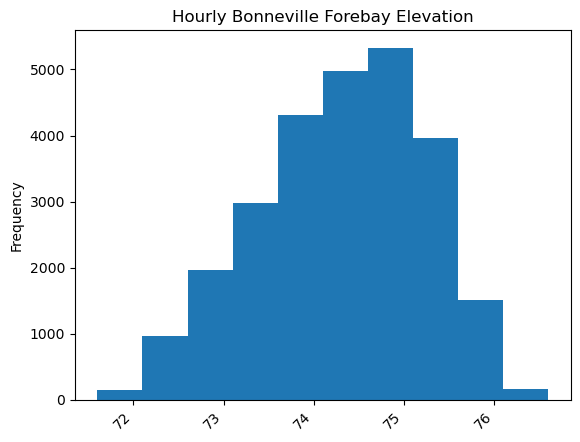

In [22]:
plt.hist(bon_hourly['BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]'])
plt.title('Hourly Bonneville Forebay Elevation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

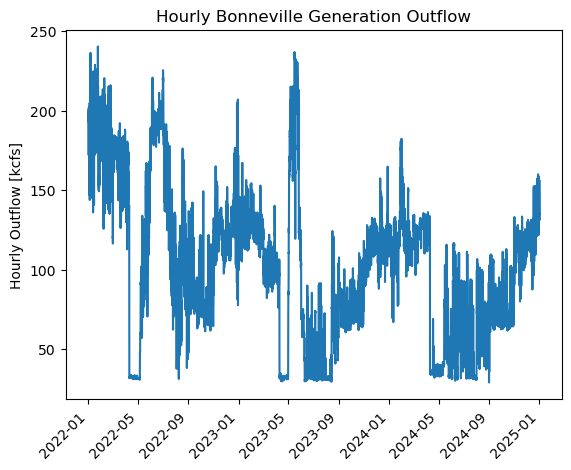

In [23]:
plt.plot(bon_hourly['Date Time'], bon_hourly['BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]'])
plt.title('Hourly Bonneville Generation Outflow')
plt.ylabel('Hourly Outflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

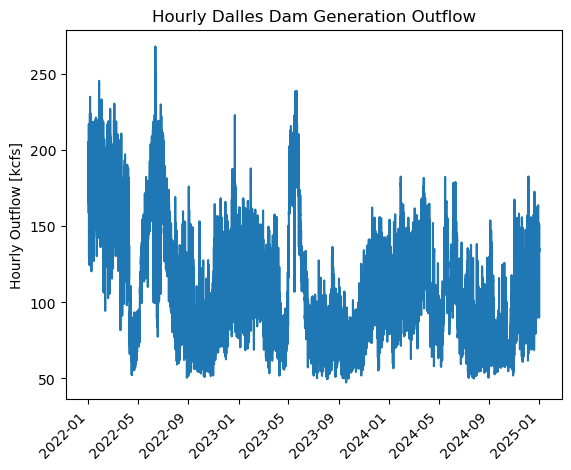

In [24]:
plt.plot(tda_hourly['Date Time'], tda_hourly['TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]'])
plt.title('Hourly Dalles Dam Generation Outflow')
plt.ylabel('Hourly Outflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

## Fitting the Hydraulic Head Function

In [26]:
bon_storage_path = bon_path + "BON6S_daily.csv"
tda_storage_path = tda_path + "TDA6S_daily.csv"

In [27]:
bon_storage = pd.read_csv(bon_storage_path)
tda_storage = pd.read_csv(tda_storage_path)

In [28]:
bon_storage = bon_storage.rename(columns={"S (unit:cfs)": "bon_S_cfs"})
bon_storage["bon_S_cumcfs"] = bon_storage["bon_S_cfs"].cumsum()

# cfs‑days → acre‑feet → cubic metres
bon_storage["bon_S_m3"] = af_to_m3(
    cfs_to_af(bon_storage["bon_S_cumcfs"])
)

In [29]:
tda_storage["tda_S_cumcfs"] = tda_storage["S (unit:cfs)"].cumsum()

# cfs‑days → acre‑feet → cubic metres
tda_storage["tda_S_m3"] = af_to_m3(
    cfs_to_af(tda_storage["tda_S_cumcfs"])
)

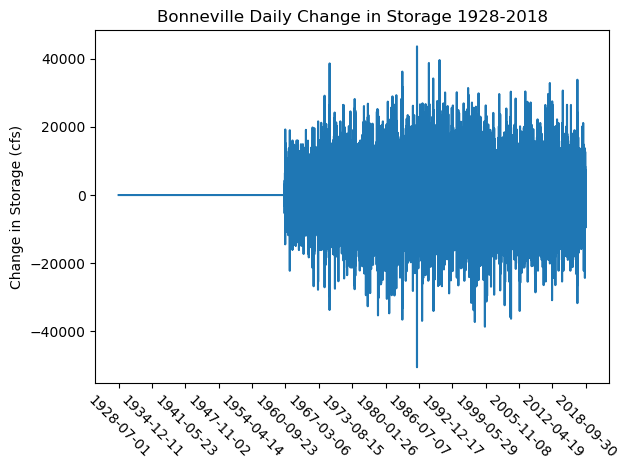

In [30]:
fig, ax = plt.subplots()
ax.plot(bon_storage.date,bon_storage.bon_S_cfs)

# Set exactly 15 x-axis ticks
ticks = np.linspace(0, len(bon_storage.date) - 1, 15).astype(int)
ax.set_xticks(bon_storage.date.iloc[ticks])
ax.set_xticklabels(bon_storage.date.iloc[ticks], rotation=-45)
plt.title("Bonneville Daily Change in Storage 1928-2018")
plt.ylabel("Change in Storage (cfs)")
plt.tight_layout()
plt.show()

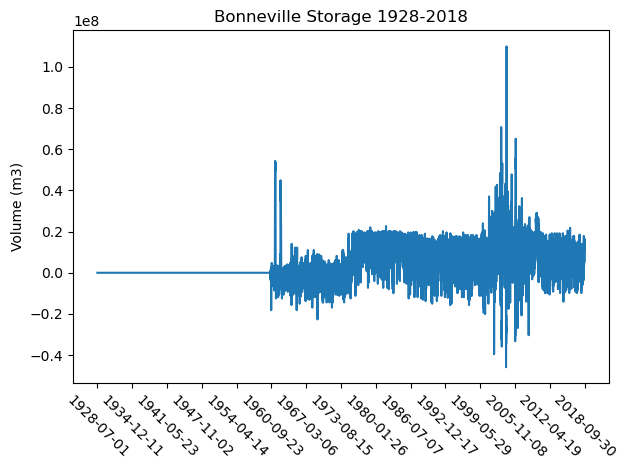

In [31]:
fig, ax = plt.subplots()
ax.plot(bon_storage.date, bon_storage.bon_S_m3)

# Set exactly 15 x-axis ticks
ticks = np.linspace(0, len(bon_storage.date) - 1, 15).astype(int)
ax.set_xticks(bon_storage.date.iloc[ticks])
ax.set_xticklabels(bon_storage.date.iloc[ticks], rotation=-45)
plt.title("Bonneville Storage 1928-2018")
plt.ylabel("Volume (m3)")
plt.tight_layout()
plt.show()

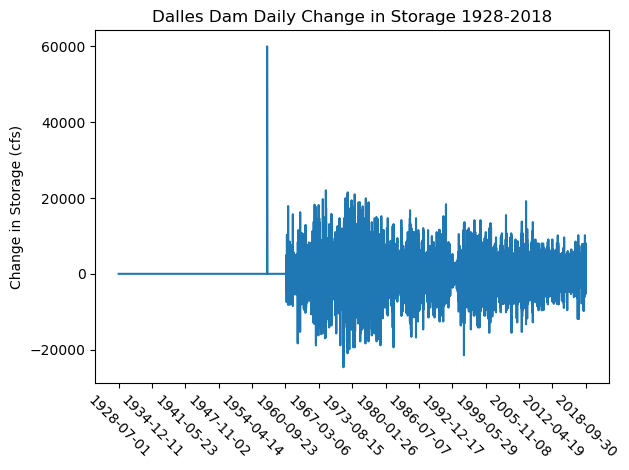

In [32]:
fig, ax = plt.subplots()
ax.plot(tda_storage.date,tda_storage["S (unit:cfs)"])

# Set exactly 15 x-axis ticks
ticks = np.linspace(0, len(tda_storage.date) - 1, 15).astype(int)
ax.set_xticks(tda_storage.date.iloc[ticks])
ax.set_xticklabels(tda_storage.date.iloc[ticks], rotation=-45)
plt.title("Dalles Dam Daily Change in Storage 1928-2018")
plt.ylabel("Change in Storage (cfs)")
plt.tight_layout()
plt.show()

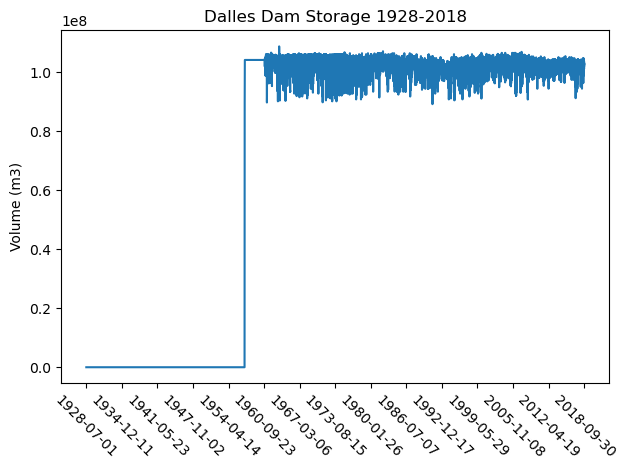

In [33]:
fig, ax = plt.subplots()
ax.plot(bon_storage.date, tda_storage.tda_S_m3)

# Set exactly 15 x-axis ticks
ticks = np.linspace(0, len(tda_storage.date) - 1, 15).astype(int)
ax.set_xticks(tda_storage.date.iloc[ticks])
ax.set_xticklabels(tda_storage.date.iloc[ticks], rotation=-45)
plt.title("Dalles Dam Storage 1928-2018")
plt.ylabel("Volume (m3)")
plt.tight_layout()
plt.show()

In [34]:
def daily_merge(storage_df, hh_df, storage_date_col, hh_datetime_col, forebay_col, start, end): 

    # Parse dates
    storage = storage_df.copy()
    hh      = hh_df.copy()
    storage[storage_date_col] = pd.to_datetime(storage[storage_date_col])
    hh[hh_datetime_col]       = pd.to_datetime(hh[hh_datetime_col])

    # Compute column-wise daily mean for hourly hh
    hh_daily = (
        hh
        .set_index(hh_datetime_col)
        .resample("D")
        .mean()                      
        .reset_index()
        .rename(columns={hh_datetime_col: storage_date_col})
    )

    # Merge dfs on date column
    merged = pd.merge(
        storage,
        hh_daily,
        on=storage_date_col,
        how="inner"               
    )

    merged = merged.rename(columns={forebay_col: "hh_ft"})
    merged["hh_m"] = ft_to_m(merged.hh_ft)

    # Slice the requested window
    mask = (merged[storage_date_col] >= start) & (merged[storage_date_col] <= end)
    
    return merged.loc[mask].reset_index(drop=True)


### Bonneville Hydraulic Head

In [36]:
bon_hourly["forebay_m"] = ft_to_m(bon_hourly["BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]"])

In [37]:
bon_hh_merge = bon_hourly[["forebay_m", "storage_m3"]]

storage_col="storage_m3"
head_col="forebay_m"

In [38]:
bon_hh_merge.head()

,forebay_m,storage_m3
0,22.584578,844193712.0
1,22.615056,849374328.0
2,22.645535,851964636.0
3,22.645535,854554944.0
4,22.645535,854554944.0


In [39]:
nan_rows = bon_hh_merge[bon_hh_merge[head_col].isna()]
print(nan_rows)

      forebay_m   storage_m3
7363        NaN  870096792.0


In [40]:
bon_hh_merge = bon_hh_merge.dropna()

In [41]:
## Apply OLS to positive subset 
import statsmodels.api as sm
from scipy.optimize import curve_fit

X = sm.add_constant(np.log(bon_hh_merge[storage_col]))     # adds intercept = log a
y = np.log(bon_hh_merge[head_col])

ols = sm.OLS(y, X).fit()
log_a, bon_b = ols.params
bon_a = np.exp(log_a)

print(f"OLS result:  a = {bon_a:.4g},  b = {bon_b:.4g}")

OLS result:  a = 0.002642,  b = 0.4404


In [42]:
def predict_head(V, a, b):
    return a * (V)**b

In [43]:
def hh_plot(pos_df, neg_df, storage_col, head_col, min_oper_level, max_oper_level, a_param, b_param):

    figsize = (10, 3)

    # Plot Characteristics
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        pos_df[storage_col], pos_df[head_col],
        alpha=0.8, color="tab:blue", label=f"Volume [m3] ≥ 0"
    )
    
    if neg_df is not None:
        ax.scatter(
            neg_df[storage_col], neg_df[head_col],
            alpha=0.25, color="lightskyblue", label=f"Volume [m3] < 0"
        )

    eqn_label = rf"$h(t) = {a_param:.2g}\,V(t)^{{{b_param:.1g}}}$"  
    ax.plot(
        x_line,
        pred_head,
        color="red",
        linewidth=2.0,
        label=eqn_label 
    )

    ax.axhline(min_oper_level, color="orange",  ls="--",
               label="Minumum Forebay [m]")
    ax.axhline(max_oper_level, color="orange",    ls="--",
               label="Maximum Forebay [m]")
    
    ax.set_ylabel("Avg. Daily Forebay Elevation [m]")
    ax.set_xlabel("Daily Reservoir Volume [m3]")
    ax.set_title(f"Reservoir Volume over Forebay Elevation")
    ax.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", frameon=False)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

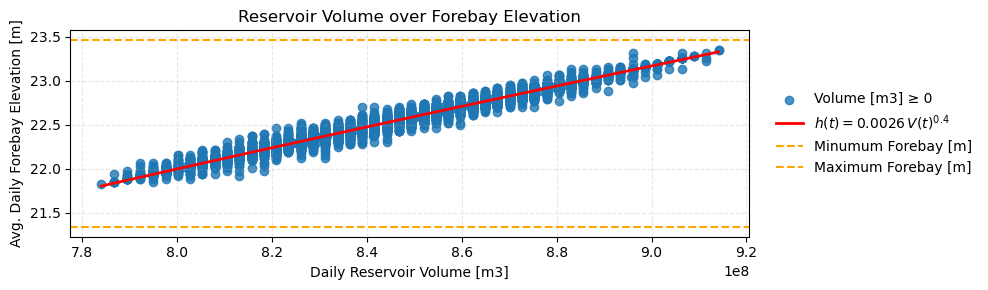

In [44]:
storage_col="storage_m3"
head_col="forebay_m"

x_line = np.linspace(
    bon_hh_merge[storage_col].min(),    
    bon_hh_merge[storage_col].max(),                 
    400                                     
)

pred_head = predict_head(x_line, bon_a, bon_b)

# Scatter each set seperately 
hh_plot(
    pos_df=bon_hh_merge,
    neg_df = None,
    storage_col=storage_col,
    head_col=head_col, 
    min_oper_level = ft_to_m(70),
    max_oper_level = ft_to_m(77),
    a_param = bon_a, 
    b_param = bon_b
)

## Dalles Dam Hydraulic Head

In [46]:
tda_hh_merge = daily_merge(
    storage_df=tda_storage,
    hh_df=tda_hh,
    storage_date_col="date",
    hh_datetime_col="Date Time",
    forebay_col = "TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]",
    start="2016-01-01",
    end="2018-12-31",
)

In [47]:
tda_hh_merge.tail()

,date,S (unit:cfs),tda_S_cumcfs,tda_S_m3,hh_ft,hh_m
999,2018-09-26,-418,163828,1.018798e+08,158.563750,48.327873
1000,2018-09-27,781,164609,1.023655e+08,158.827500,48.408260
1001,2018-09-28,222,164831,1.025035e+08,159.000417,48.460962
1002,2018-09-29,1028,165859,1.031428e+08,159.138750,48.503124
1003,2018-09-30,-2773,163086,1.014184e+08,158.940833,48.442802


In [48]:
len(tda_hh_merge)

1004

In [49]:
## Count of negative volume instances

neg_count = (tda_hh_merge["tda_S_m3"] < 0).sum()
neg_count

0

In [50]:
storage_col="tda_S_m3"
head_col = "hh_m"

## Apply OLS  
X = sm.add_constant(np.log(tda_hh_merge[storage_col]))     # adds intercept = log a
y = np.log(tda_hh_merge[head_col])

ols = sm.OLS(y, X).fit()
log_a, tda_b = ols.params
tda_a = np.exp(log_a)

print(f"OLS result:  a = {tda_a:.4g},  b = {tda_b:.4g}")

OLS result:  a = 4.086,  b = 0.134


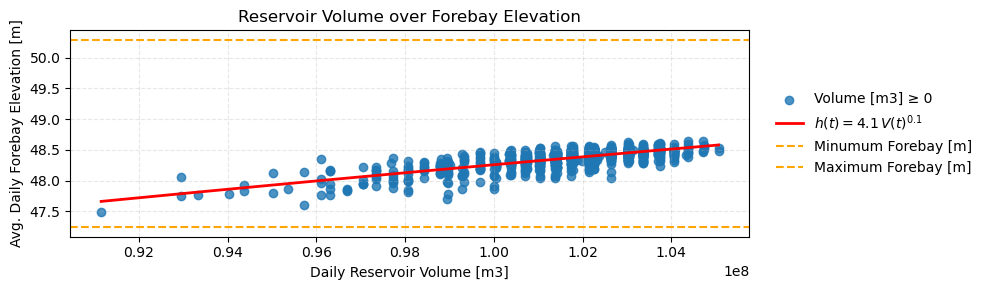

In [51]:
x_line = np.linspace(
    tda_hh_merge[storage_col].min(),    
    tda_hh_merge[storage_col].max(),                 
    400                                     
)

pred_head = predict_head(x_line, tda_a, tda_b)

# Scatter each set seperately 
hh_plot(
    pos_df=tda_hh_merge,
    neg_df = None,
    storage_col=storage_col,
    head_col=head_col, 
    min_oper_level = ft_to_m(155),
    max_oper_level = ft_to_m(165),
    a_param = tda_a, 
    b_param = tda_b
)

### Checking Initial Conditions

In [53]:
predict_head(af_to_m3(697000), bon_a, bon_b) ## WITHIN BOUNDS :-)

22.707925506157746

In [54]:
predict_head(af_to_m3(303710), tda_a, tda_b) # OUT OF BOUNDS !! BECAUSE MATCHING US ACE CURRENT STORAGE TO 2018 CURVE FIT --> WILL REDO 

57.6049729155959

## Interpolating Daily Inflow Data

### Identifying Missing Data

In [57]:
full_range = pd.date_range(start=tda_hourly['Date Time'].min(),
                           end=tda_hourly['Date Time'].max(),
                           freq='h')  # for hourly data

In [58]:
has_leap_day = any((full_range.month == 2) & (full_range.day == 29))
print("Leap day present:", has_leap_day)

Leap day present: True


In [59]:
len(full_range)

26304

In [60]:
len(tda_hourly)

26272

In [61]:
len(full_range) - len(tda_hourly)

32

In [62]:
# Convert to sets for fast comparison
actual_timestamps = set(tda_hourly['Date Time'])
expected_timestamps = set(full_range)

missing_timestamps = sorted(expected_timestamps - actual_timestamps)

In [63]:
missing_timestamps

[Timestamp('2022-06-07 12:00:00'),
 Timestamp('2022-06-13 21:00:00'),
 Timestamp('2022-06-14 00:00:00'),
 Timestamp('2022-06-14 02:00:00'),
 Timestamp('2022-06-20 20:00:00'),
 Timestamp('2022-06-21 09:00:00'),
 Timestamp('2022-06-22 11:00:00'),
 Timestamp('2022-06-23 00:00:00'),
 Timestamp('2022-06-30 15:00:00'),
 Timestamp('2022-11-09 20:00:00'),
 Timestamp('2022-11-09 21:00:00'),
 Timestamp('2022-11-09 22:00:00'),
 Timestamp('2022-11-09 23:00:00'),
 Timestamp('2022-11-10 00:00:00'),
 Timestamp('2022-11-10 02:00:00'),
 Timestamp('2022-11-10 04:00:00'),
 Timestamp('2022-11-10 05:00:00'),
 Timestamp('2022-11-10 06:00:00'),
 Timestamp('2022-11-10 08:00:00'),
 Timestamp('2022-11-10 10:00:00'),
 Timestamp('2022-11-10 11:00:00'),
 Timestamp('2022-11-10 12:00:00'),
 Timestamp('2022-11-10 15:00:00'),
 Timestamp('2022-11-10 16:00:00'),
 Timestamp('2022-11-10 17:00:00'),
 Timestamp('2022-11-10 18:00:00'),
 Timestamp('2022-11-10 20:00:00'),
 Timestamp('2023-10-14 20:00:00'),
 Timestamp('2023-10-

### Interpolation

In [65]:
tda = tda_hourly.copy()

In [66]:
tda = tda.rename(columns={"TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]": 'inflow_kcfs'})
tda = tda.rename(columns={"Date Time": 'datetime'})
tda = tda[['datetime', 'inflow_kcfs']]

In [67]:
missing_df = pd.DataFrame(index=missing_timestamps, columns=['inflow_kcfs'])
missing_df = missing_df.reset_index().rename(columns={'index': 'datetime'})

In [68]:
tda = pd.concat([tda, missing_df])

/var/folders/w1/xfz4_86j0zg0zz10g620bhz00000gn/T/ipykernel_99751/2196797759.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tda = pd.concat([tda, missing_df])


In [69]:
# Resort tda dataframe based on datetime column to fix imputed data
tda.sort_values("datetime", ascending=True, inplace=True)  

In [70]:
tda = tda.reset_index(drop=True)

In [71]:
# Fill Forwards with last collection point
tda['inflow_kcfs'] = tda['inflow_kcfs'].ffill()

In [72]:
# Fill Backwards for first time step 
tda['inflow_kcfs'] = tda['inflow_kcfs'].bfill()

In [73]:
save_path = "/Users/elizacohn/Desktop/cascaded-hydro/simulation-data/tda-inflow-USACE.csv"
tda.to_csv(save_path, index=False)

In [74]:
len(tda)

26304

In [75]:
tda.tail()

,datetime,inflow_kcfs
26299,2024-12-31 19:00:00,152.653
26300,2024-12-31 20:00:00,152.653
26301,2024-12-31 21:00:00,152.653
26302,2024-12-31 22:00:00,152.653
26303,2024-12-31 23:00:00,152.653


In [76]:
tda.isna().sum()

datetime       0
inflow_kcfs    0
dtype: int64

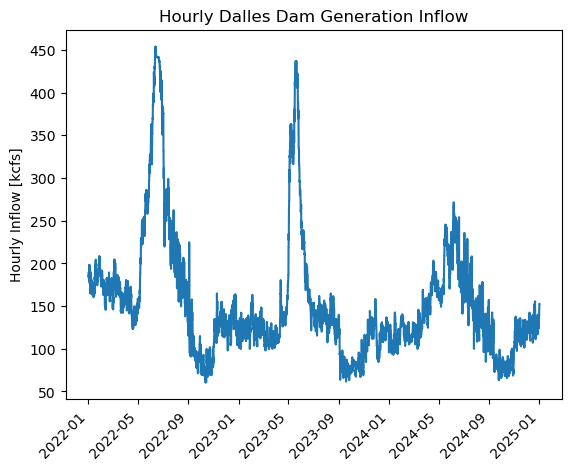

In [77]:
plt.plot(tda['datetime'], tda['inflow_kcfs'])
plt.title('Hourly Dalles Dam Generation Inflow')
plt.ylabel('Hourly Inflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

## Calculate Ramp Rate & Release Rate Constraint

In [79]:
def ramp_rate(df, flow_col):

    # Assume df is sorted by time and looks like:
    # df['Date Time']: datetime64[ns]
    # df['Release']: float
    
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    
    # Calculate time difference in hours
    df['Time_Diff_hrs'] = df['Date Time'].diff().dt.total_seconds() / 3600
    
    # Calculate flow difference
    df['Flow_Diff'] = df[flow_col].diff()
    
    # Compute ramp rate (cfs per hour)
    df['Ramp_Rate'] = df['Flow_Diff'] / df['Time_Diff_hrs']

    return df

In [80]:
def plot_hist_with_quantiles(
    df, site, type, column, lower_q, upper_q, bins=50
):
    """
    Plots a histogram of a column with two quantile lines.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): Column name to plot.
        lower_q (float): Lower quantile (e.g., 0.25).
        upper_q (float): Upper quantile (e.g., 0.75).
        bins (int): Number of histogram bins.
    """
    
    # Drop NA values
    data = df[column].dropna()

    # Compute quantiles
    q_low = data.quantile(lower_q)
    q_high = data.quantile(upper_q)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)

    # Plot quantile lines
    for q, label in zip(
        [q_low, q_high],
        [f'{int(lower_q * 100)}th percentile: {q_low:.2f}', f'{int(upper_q * 100)}th percentile: {q_high:.2f}']
    ):
        plt.axvline(q, color='red', linestyle='--', linewidth=1.5, label=label)

    # Formatting
    plt.xlabel(column)
    plt.ylabel('Frequency')
    # plt.xlim([-30, 30])
    plt.title(f'Histogram of {site} {type} with Quantiles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [81]:
bon_hourly = ramp_rate(bon_hourly, 'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]')

In [82]:
bon_hourly.head()

,Date Time,BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],storage_m3,forebay_m,Time_Diff_hrs,Flow_Diff,Ramp_Rate
0,2022-01-01 00:00:00,74.1,194.6,NaN,198.1,844193712.0,22.584578,NaN,NaN,NaN
1,2022-01-01 01:00:00,74.2,194.1,185.84,197.6,849374328.0,22.615056,1.0,-0.5,-0.5
2,2022-01-01 02:00:00,74.3,194.7,NaN,198.2,851964636.0,22.645535,1.0,0.6,0.6
3,2022-01-01 03:00:00,74.3,194.3,NaN,197.8,854554944.0,22.645535,1.0,-0.4,-0.4
4,2022-01-01 04:00:00,74.3,193.2,NaN,196.7,854554944.0,22.645535,1.0,-1.1,-1.1


In [83]:
tda_hourly = ramp_rate(tda_hourly, 'TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]')

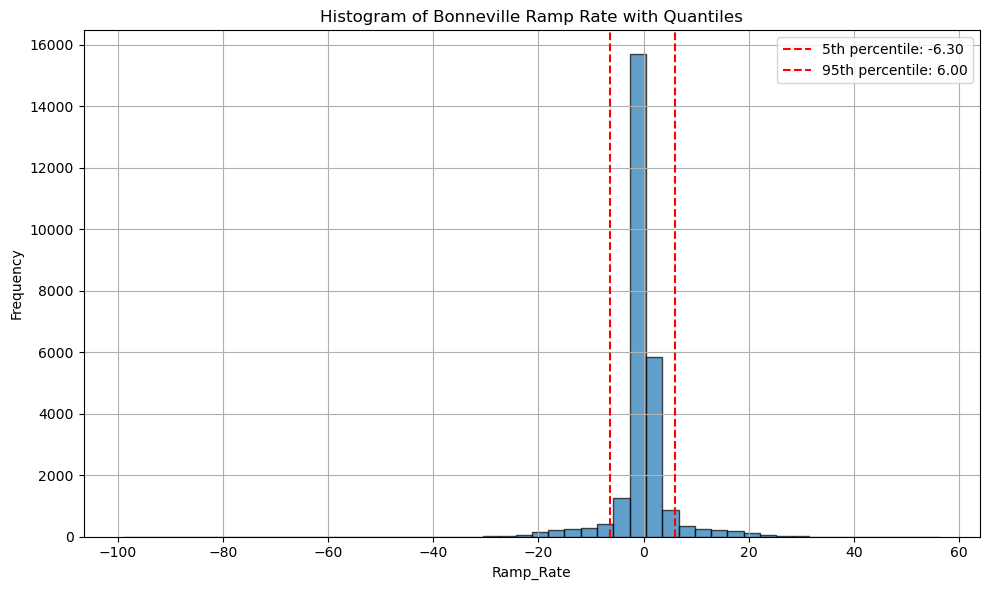

In [84]:
plot_hist_with_quantiles(bon_hourly, 'Bonneville', 'Ramp Rate', 'Ramp_Rate', lower_q=0.05, upper_q=0.95)

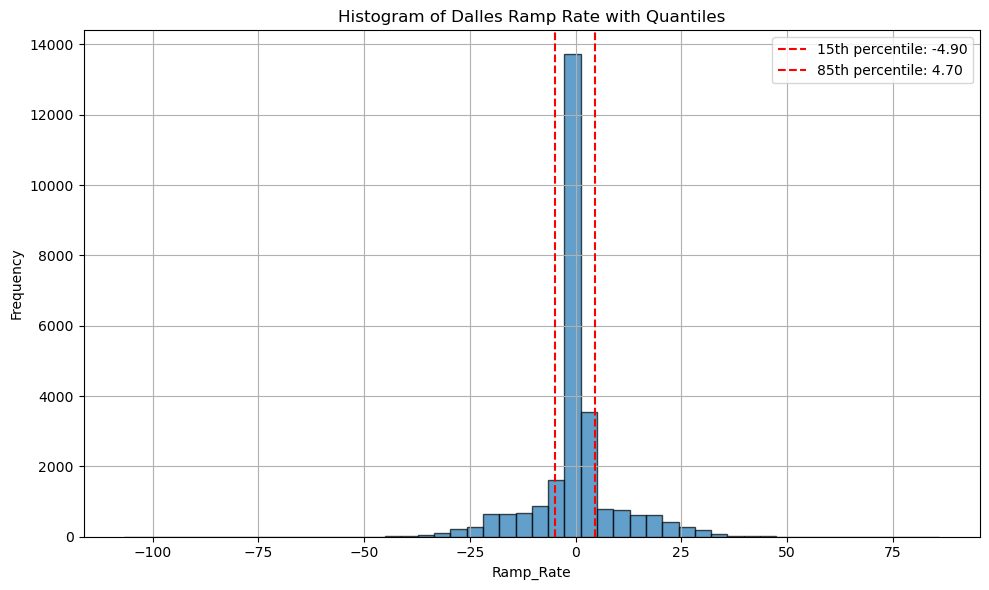

In [85]:
plot_hist_with_quantiles(tda_hourly, 'Dalles', 'Ramp Rate', 'Ramp_Rate', lower_q=0.15, upper_q=0.85)

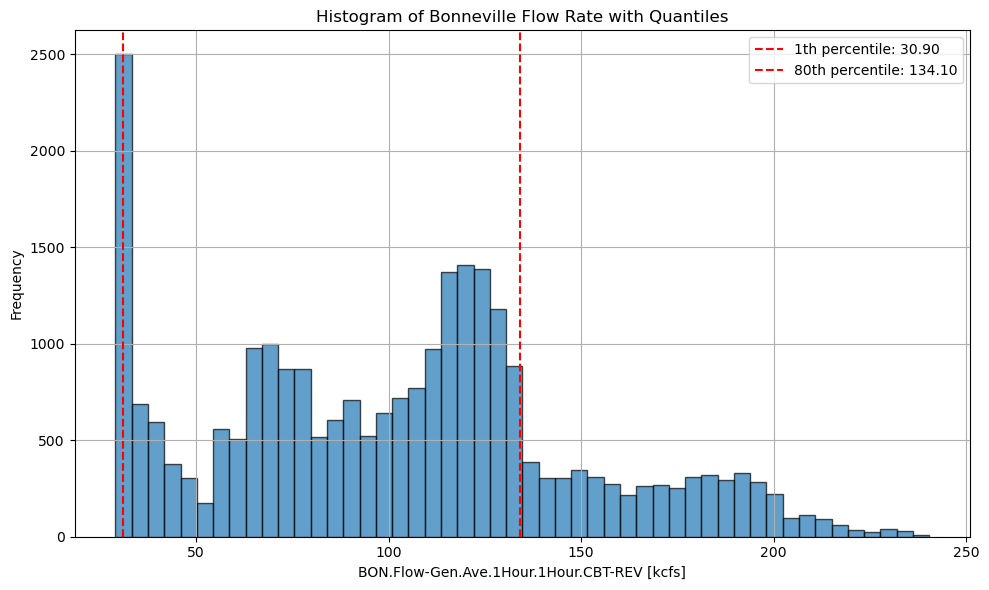

In [86]:
plot_hist_with_quantiles(bon_hourly, 'Bonneville', 'Flow Rate', 'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]', lower_q=0.01, upper_q=0.80)

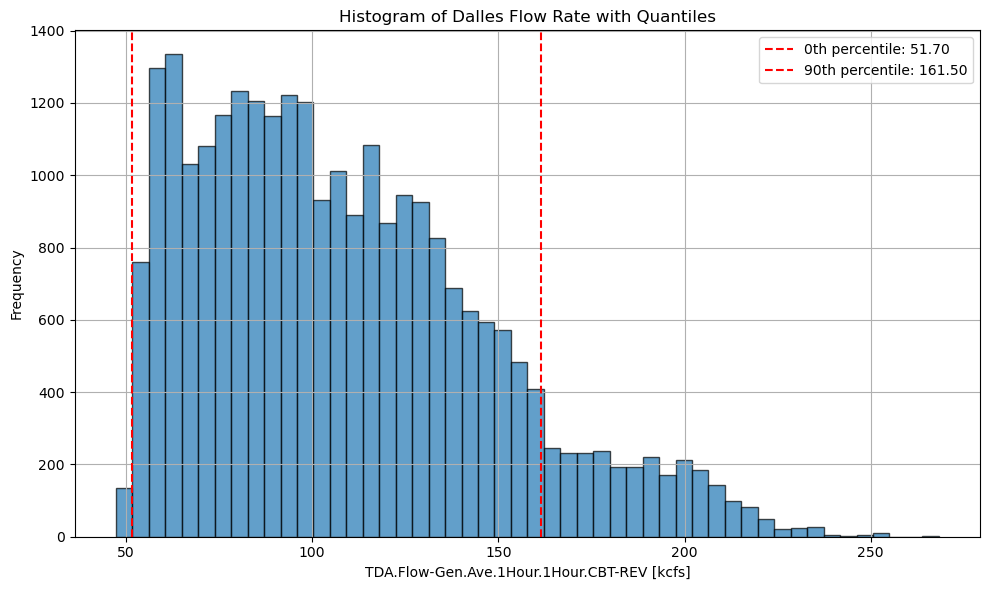

In [87]:
plot_hist_with_quantiles(tda_hourly, 'Dalles', 'Flow Rate', 'TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]', lower_q=0.005, upper_q=0.90)